<a href="https://colab.research.google.com/github/BrenoBaronte/stock-market-predictions/blob/main/Trabalho_Final_simple_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Step 0 - importing the dataset file
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '12bWmhsQoeAOk2JLCOzlRsk0IMQaKD6s2'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset_daily_msft_training.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset_train = pd.read_csv('dataset_daily_msft_training.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [ ]:
dataset_train.head()

,timestamp,open,high,low,close,volume
0,2011-08-25,25.08,25.16,24.50,24.57,48192000
1,2011-08-24,24.65,24.93,24.42,24.90,45329700
2,2011-08-23,24.03,24.75,24.03,24.72,59670600
3,2011-08-22,24.42,24.49,23.79,23.98,54721000
4,2011-08-19,24.41,24.62,23.91,24.05,77397900


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set_scaled.shape

(3435, 1)

In [ ]:
X_train = []
y_train = []
for i in range(60, 3435):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
106/106 [==============================] - 10s 58ms/step - loss: 0.0104
Epoch 2/50
106/106 [==============================] - 6s 59ms/step - loss: 0.0018
Epoch 3/50
106/106 [==============================] - 6s 58ms/step - loss: 0.0014
Epoch 4/50
106/106 [==============================] - 6s 59ms/step - loss: 0.0015
Epoch 5/50
106/106 [==============================] - 6s 59ms/step - loss: 0.0010
Epoch 6/50
106/106 [==============================] - 6s 58ms/step - loss: 0.0013
Epoch 7/50
106/106 [==============================] - 6s 58ms/step - loss: 0.0010
Epoch 8/50
106/106 [==============================] - 6s 59ms/step - loss: 0.0011
Epoch 9/50
106/106 [==============================] - 6s 58ms/step - loss: 9.1959e-04
Epoch 10/50
106/106 [==============================] - 6s 59ms/step - loss: 9.7747e-04
Epoch 11/50
106/106 [==============================] - 6s 58ms/step - loss: 8.7678e-04
Epoch 12/50
106/106 [==============================] - 6s 59ms/step - loss: 7.2557e

In [ ]:
#getting test data

file_id = '10oiV6jvHGtiXgDDJmMByxBhiyYKjaQCw'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset_daily_msft_test.csv')

In [ ]:
dataset_test = pd.read_csv('dataset_daily_msft_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
dataset_test.shape

(1849, 6)

In [ ]:
dataset_test.head()

,timestamp,open,high,low,close,volume
0,2019-01-02,99.55,101.75,98.94,101.12,35329345
1,2018-12-31,101.29,102.40,100.44,101.57,33173765
2,2018-12-28,102.09,102.41,99.52,100.39,38169312
3,2018-12-27,99.30,101.19,96.40,101.18,49498509
4,2018-12-26,95.14,100.69,93.96,100.56,51634793


In [ ]:
dataset_total = pd.concat((dataset_train['open'], dataset_test['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1909): # 1909 is dataset_test x shape + 60, this 60 is days to look back
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

1.4422432957359343

In [ ]:
plt.rcParams['figure.figsize'] = (25,15)

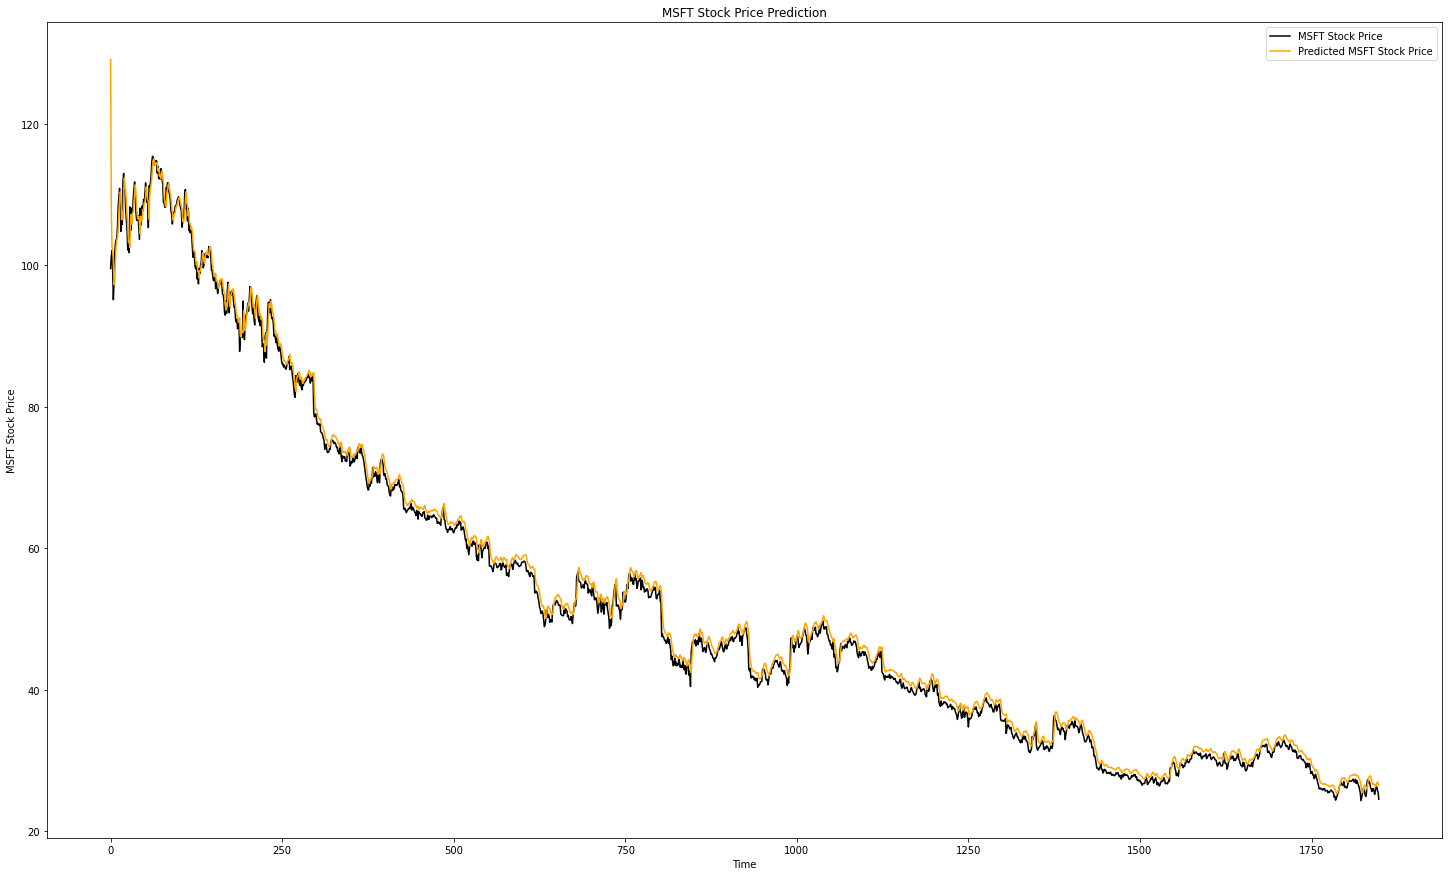

In [ ]:
plt.plot(real_stock_price, color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted MSFT Stock Price', linestyle = 'solid')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()